#TRAXIÓN: PRUEBA TÉCNICA

### Contexto:

Se desarrolla una **app móvil** para identificar las razones de **alta rotación de conductores**. La app contiene **quejas** etiquetadas según el **área** (finanzas, RH, y operaciones). La app contiene **variables** como: experiencia de viaje, evaluación del conductor, o cualquier otra que se considere de utilidad y sea sensata.

### Planteamiento:

Fruto de la pandemia de COVID hay una fuerte demanda de conductores. La gran mayoría de conductores que renuncian [no cambian de industria]((https://www.trucking.org/news-insights/truth-about-trucking-turnover), sino que cambian de patrón a cambio de incrementos salaries y/o bonos. Según la [CANACAR](https://canacar.com.mx/este-plan-canacar-reducir-deficit-operadores/), en México también tenemos este déficit. La demanda de conductores genera presiones inflacionarias que resultan en "pirataje de conductores".

De acuerdo a la CANACAR estas son algunas de las principales causas de rotación:

*   Sobrecarga laboral y largas jornadas
*   Baja remuneración y falta de incentivos
*   Escasas oportunidades de capacitación y desarrollo profesional
*   Condiciones laborales desfavorables
*   Competencia en el mercado y migración de talento

Teniendo esto en cuenta, se propone que la aplicación contenga las siguientes
variables:

Registradas en la app:

- ID de la queja
- ID del conductor
- Fecha y hora en la que se registró la queja
- Área de la queja (Finanzas, Recursos Humanos u Operaciones)
- Descripción (Texto libre, máximo 250 caracteres)

Datos del conductor

- ID del conductor
- Edad
- Años de experiencia en la industria del transporte
- Fecha de contratación
- Salario
- Cantidad de viajes realizados
- KM recorridos totales
- Tiempo de inactividad total en viajes (en minutos)
- Número de incidentes de riesgo (asaltos, robos)
- Estado de contrato (Activo, Baja)

## Generación de datos

### Datos de los conductores

In [ ]:
import uuid
import numpy as np
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta

In [ ]:
# Hay entre 4000 y 5000 empleados contratados
random_seed = 42 # Semilla para que la generación sea reproducible
rng = np.random.default_rng(random_seed)

n = rng.integers(4000,5000, size = 1)[0]

# Crear el dataframe
df = pd.DataFrame()

# Edad, 66% entre 32 y 48, 96% entre 24 y 56, 100% entre 20 y 60
df['Edad'] = rng.normal(loc=40, scale=8, size=n)
df['Edad'] = np.clip(df['Edad'], 20, 60).astype(int)

df['ID empleado'] = [uuid.uuid4() for _ in range(len(df))]

# Fecha de contratación, depende de la edad
def generar_fecha_contratacion(edad):
    # Se asume que una persona comienza a trabajar minimo a los 19
    max = min(edad - 19, 30)
    año_contratacion = rng.uniform(1, max, size = 1)[0]
    fecha_contratacion = pd.to_datetime('03/01/2025') - relativedelta(days = int(año_contratacion*365))
    return fecha_contratacion

df['Fecha contratacion'] = df['Edad'].apply(generar_fecha_contratacion)

# Años de experiencia en la industria del transporte, depende de la edad
def generar_exp(edad):
    max = edad - 19
    exp = int(rng.uniform(0, max, size = 1)[0])
    return exp

df['Años de experiencia'] = df['Edad'].apply(generar_exp)

# Cantidad de viajes realizados, depende de la fecha de contratación
def generar_viajes(contratacion):
   duracion = (pd.to_datetime('03/01/2025') - contratacion).days
   # Se asume que se realiza un viaje cada 1 o 2 dias
   duracion = int(duracion*rng.uniform(.5, .9, size = 1)[0])
   return duracion

df['Viajes realizados'] = df['Fecha contratacion'].apply(generar_viajes)

# KM recorridos totales, depende de la fecha de contratación
df['Km totales recorridos'] = (pd.to_datetime('03/01/2025') - df['Fecha contratacion']).dt.days
# Se asume que un viaje promedio dura 350km
df['Km totales recorridos'] = (df['Km totales recorridos']*rng.normal(loc=350, scale=80, size=n)).astype(int)

# Tiempo de inactividad, depende de los viajes realizados y sus km totales recorridos
# Primero se crea una metrica que combine los viajes realizados y los km totales recorridos y se obtiene el promedio de esta metrica por dia trabajado
df['Tiempo de inactividad total'] = (df['Viajes realizados'] * df['Km totales recorridos'])/(pd.to_datetime('03/01/2025') - df['Fecha contratacion']).dt.days
# Entre mas diste esta metrica del trabajador mas sobresaliente, mas tiempo de inactividad se asigna
# Se asume un tiempo de inactividad base de 60 minutos por viaje
df['Tiempo de inactividad total'] = (1.1 - df['Tiempo de inactividad total']/max(df['Tiempo de inactividad total']))*rng.normal(loc=60, scale=15, size=n)
df['Tiempo de inactividad total'] = (df['Tiempo de inactividad total']*df['Viajes realizados']).astype(int)

# Numero de incidentes, depende de los viajes realizados
df['Incidentes de peligro'] = (df['Viajes realizados']*rng.beta(1, 3000, size=n)).astype(int)

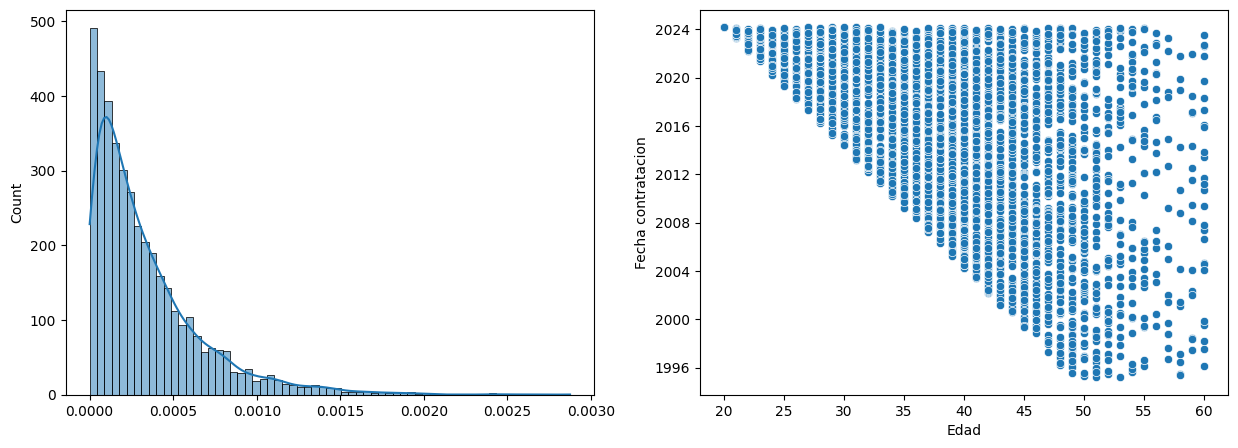

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(rng.beta(1, 3000, size=n), kde=True, ax=axes[0])
sns.scatterplot(data=df, x="Edad", y="Fecha contratacion", ax=axes[1])

plt.show()

In [ ]:
df.head()


,Edad,ID empleado,Fecha contratacion,Años de experiencia,Viajes realizados,Km totales recorridos,Tiempo de inactividad total,Incidentes de peligro
0,31,076195d4-5e68-4ea4-96cf-0e423fcec136,2023-01-08,4,701,250537,35730,0
1,46,ee59fbe8-fe72-4ddb-8da0-9be6b646b5d1,2020-09-08,11,1404,478993,57174,0
2,47,1defc92c-89b7-41ea-b8bc-4ad127f94872,2022-04-15,20,914,233251,86084,0
3,24,80650338-cacd-41de-97b8-7f4d3b552a58,2022-03-12,4,635,454205,34626,0
4,29,e35cc89d-27e8-4af0-a688-b0717f773e43,2023-06-10,3,451,233591,31094,0


### Comentarios generados por IA

In [ ]:
import pandas as pd
# Importar los datos con los comentarios
comentarios = pd.read_csv('comentarios_texto.csv', encoding ='latin1')

# Guardar los comentarios como listas
comentarios['Comentarios'] = comentarios['Comentarios'].apply(lambda x: eval(x))

# Obtener la longitud de cada listas
comentarios['longitud'] = comentarios['Comentarios'].apply(lambda x: len(x))

In [ ]:
comentarios.head()

,Area,Positividad,Modelo,Comentarios,longitud
0,Finanzas,0.50,GPT 4,"[El pago llegó, pero tardó más de lo esperado,...",225
1,Finanzas,0.25,GPT 4,[El pago de esta semana fue más bajo de lo esp...,329
2,Finanzas,0.00,GPT 4,"[Me descontaron dinero sin explicación, No rec...",335
3,RH,0.50,GPT 4,[El supervisor no escucha nuestras preocupacio...,294
4,RH,0.25,GPT 4,[El supervisor no escucha nuestras preocupacio...,275


In [ ]:
# Hay entre 4000 y 5000 quejas empleados contratados
m =  rng.integers(4500,5000, size = 1)[0]

# Crear el dataframe
quejas = pd.DataFrame()

# Muestreamos con repetición las filas de la base de quejas
quejas[['Area','Comentarios','Positividad']] = comentarios[['Area','Comentarios','Positividad']].sample(m, replace = True, random_state=random_seed).values

# Por cada muestreo, a su vez se extrae un comentario aleatorio
quejas['Comentarios'] = quejas['Comentarios'].apply(lambda x: rng.choice(x))

quejas['Negatividad'] = 1- quejas['Positividad']

quejas['ID queja'] = [uuid.uuid4() for _ in range(len(quejas))]

# Asignamos un ID de empleado aleatorio
quejas['ID empleado'] = df['ID empleado'].sample(m, replace = True, random_state=random_seed).values

In [ ]:
quejas.head()

,Area,Comentarios,Positividad,Negatividad,ID queja,ID empleado
0,Operaciones,Tardaron mucho en asignarme una ruta y me retrasé,0.5,0.5,d3d2e94a-606b-4f93-b10c-02a9e4d6d32a,65089661-2553-4943-b45c-97679f3b7dbf
1,RH,"La carga de trabajo es algo pesada, pero se pu...",0.5,0.5,dcfff63d-810a-439c-a455-40b1c370f7b8,c80ae28f-d04a-48eb-b918-a460792f5dae
2,Operaciones,El coordinador no me avisó sobre el tráfico en...,0.25,0.75,b220b7bf-0b1f-4c68-89b9-fc9c4d9b6ca5,4d03cb6e-9879-4134-97e7-aeda5396215b
3,RH,Los supervisores podrían ser más atentos,0.25,0.75,88a29c78-2cff-4f89-a4e2-8d739046be9b,bb1338b3-3f88-47eb-b426-bfa2f5d5ed75
4,Operaciones,La falta de apoyo del coordinador me causó muc...,0.5,0.5,1c9c8fce-409f-47fc-8a4f-ecdd54cfbee8,160ed395-8805-40f8-91f8-60b3ff5ca666


### Probabilidad de renuncia

In [ ]:
quejas_por_area = quejas.pivot_table(index="ID empleado", columns="Area", aggfunc="size", fill_value=0)

# Sumar la negatividad por empleado
negatividad = quejas.groupby("ID empleado")["Negatividad"].sum()

# Unir ambas tablas
quejas_wide = negatividad.to_frame().join(quejas_por_area).reset_index().sort_values(by = 'Negatividad', ascending= False)
quejas_wide.head()

,ID empleado,Negatividad,Finanzas,Operaciones,RH
640,3c4eaf47-d0e3-45c4-9c6a-c5b7f762c08f,5.75,0,4,3
2540,e6034d93-ba0d-4337-80bd-6099e269f781,5.25,1,2,4
1909,af6c8fe3-d9dd-4d01-8668-ccf91c24d896,5.25,2,2,2
1832,a8a9ef40-8b32-49be-b354-18842d5158ea,4.75,2,0,3
1911,af779595-5e39-42ca-bc5e-19819cd5f42d,4.75,3,0,3


In [ ]:
total_df = df.merge(quejas_wide, on = 'ID empleado', how = 'left').fillna(0)
total_df.head()

<ipython-input-10-9ab1080a4bfc>:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  total_df = df.merge(quejas_wide, on = 'ID empleado', how = 'left').fillna(0)


,Edad,ID empleado,Fecha contratacion,Años de experiencia,Viajes realizados,Km totales recorridos,Tiempo de inactividad total,Incidentes de peligro,Negatividad,Finanzas,Operaciones,RH
0,31,076195d4-5e68-4ea4-96cf-0e423fcec136,2023-01-08,4,701,250537,35730,0,0.75,1.0,0.0,0.0
1,46,ee59fbe8-fe72-4ddb-8da0-9be6b646b5d1,2020-09-08,11,1404,478993,57174,0,3.25,0.0,3.0,1.0
2,47,1defc92c-89b7-41ea-b8bc-4ad127f94872,2022-04-15,20,914,233251,86084,0,0.50,0.0,1.0,0.0
3,24,80650338-cacd-41de-97b8-7f4d3b552a58,2022-03-12,4,635,454205,34626,0,0.75,1.0,0.0,0.0
4,29,e35cc89d-27e8-4af0-a688-b0717f773e43,2023-06-10,3,451,233591,31094,0,0.75,0.0,0.0,1.0


In [ ]:
def calcular_probabilidad_renuncia(row):

    prob = 0

    # Factores que aumentan la probabilidad

    prob += (100*row['Tiempo de inactividad total'] / row['Km totales recorridos']) # Improductivo o desmotivado

    prob += 20*row['Incidentes de peligro'] # Condiciones peligrosas

    prob += 50*row['Negatividad'] # Comentarios negativos

    prob += 20*row['RH'] # Sentimiento de insatisfacción laboral

    prob += 15*row['Finanzas'] # Insatisfacción salarial

    prob += 10*row['Operaciones'] # Mala gestión

    antiguedad = (pd.to_datetime('03/01/2025') - row['Fecha contratacion']).days
    prob += 10/antiguedad # Las personas con menos antiguedad tienen menos apego a la empresa

    # Factores que reducen la probabilidad

    prob -= 5*row['Años de experiencia'] # Mayor confianza en el rol y adaptabilidad, más busqueda de estabilidad

    prob -= row['Viajes realizados']/500 # Mayor experiencia y satisfacción

    return prob

In [ ]:
from sklearn.preprocessing import MinMaxScaler

total_df['Probabilidad Renuncia'] = total_df.apply(calcular_probabilidad_renuncia, axis=1)

# Se normalizan las puntuaciones
total_df['Probabilidad Renuncia'] = MinMaxScaler().fit_transform(total_df[['Probabilidad Renuncia']])

# Se fija un umbral
total_df['Renuncia'] = (total_df['Probabilidad Renuncia'] > .38).astype(int)
total_df['Renuncia'].sum() / len(total_df)

np.float64(0.4886280264123258)

### Resultado

In [ ]:
app_quejas = quejas[['ID queja','ID empleado','Area','Comentarios']]
app_quejas.to_csv('app_quejas.csv', index=False)
print(app_quejas.head().to_markdown(index=False))
print(app_quejas.info())
print('\n')
empleados = df.merge(total_df[['ID empleado','Renuncia']], on = 'ID empleado', how = 'left')
empleados.to_csv('empleados.csv', index=False)
print(empleados.head().to_markdown(index=False))
print(empleados.info())

| ID queja                             | ID empleado                          | Area        | Comentarios                                                 |
|:-------------------------------------|:-------------------------------------|:------------|:------------------------------------------------------------|
| d3d2e94a-606b-4f93-b10c-02a9e4d6d32a | 65089661-2553-4943-b45c-97679f3b7dbf | Operaciones | Tardaron mucho en asignarme una ruta y me retrasé           |
| dcfff63d-810a-439c-a455-40b1c370f7b8 | c80ae28f-d04a-48eb-b918-a460792f5dae | RH          | La carga de trabajo es algo pesada, pero se puede manejar   |
| b220b7bf-0b1f-4c68-89b9-fc9c4d9b6ca5 | 4d03cb6e-9879-4134-97e7-aeda5396215b | Operaciones | El coordinador no me avisó sobre el tráfico en mi ruta.     |
| 88a29c78-2cff-4f89-a4e2-8d739046be9b | bb1338b3-3f88-47eb-b426-bfa2f5d5ed75 | RH          | Los supervisores podrían ser más atentos                    |
| 1c9c8fce-409f-47fc-8a4f-ecdd54cfbee8 | 160ed395-8805-40f8-91f8

## NLP + Feature Engineering

### NLP

In [ ]:
# NLP
from transformers import pipeline

# Cargar el modelo y el tokenizador
analizador_sentimientos = pipeline("sentiment-analysis", model="edumunozsala/roberta_bne_sentiment_analysis_es")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/849 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.09k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/851k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/509k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.46M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
app_quejas['NLP'] = app_quejas['Comentarios'].apply(lambda x: analizador_sentimientos(x)[0])

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
<ipython-input-16-055eebc16de1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_quejas['NLP'] = app_quejas['Comentarios'].apply(lambda x: analizador_sentimientos(x)[0])


In [ ]:
import pandas as pd

app_quejas = pd.read_csv('app_quejas+nlp.csv')
app_quejas['NLP'] = app_quejas['NLP'].apply(eval)
empleados = pd.read_csv('empleados.csv')
empleados['Fecha contratacion'] = pd.to_datetime(empleados['Fecha contratacion'])

In [ ]:
app_quejas['Score'] = app_quejas['NLP'].apply(lambda x: x['score'])
app_quejas['Sentimiento'] = app_quejas['NLP'].apply(lambda x: x['label'])
app_quejas['Score norm'] = app_quejas["Sentimiento"].map({"Negativo": -1, "Positivo": 1})* app_quejas["Score"]
app_quejas.to_csv('app_quejas+nlp.csv', index=False)
app_quejas.head()

,ID queja,ID empleado,Area,Comentarios,NLP,Score,Sentimiento,Score norm
0,d3d2e94a-606b-4f93-b10c-02a9e4d6d32a,65089661-2553-4943-b45c-97679f3b7dbf,Operaciones,Tardaron mucho en asignarme una ruta y me retrasé,"{'label': 'Negativo', 'score': 0.9982889294624...",0.998289,Negativo,-0.998289
1,dcfff63d-810a-439c-a455-40b1c370f7b8,c80ae28f-d04a-48eb-b918-a460792f5dae,RH,"La carga de trabajo es algo pesada, pero se pu...","{'label': 'Negativo', 'score': 0.9341663122177...",0.934166,Negativo,-0.934166
2,b220b7bf-0b1f-4c68-89b9-fc9c4d9b6ca5,4d03cb6e-9879-4134-97e7-aeda5396215b,Operaciones,El coordinador no me avisó sobre el tráfico en...,"{'label': 'Negativo', 'score': 0.9991199374198...",0.999120,Negativo,-0.999120
3,88a29c78-2cff-4f89-a4e2-8d739046be9b,bb1338b3-3f88-47eb-b426-bfa2f5d5ed75,RH,Los supervisores podrían ser más atentos,"{'label': 'Negativo', 'score': 0.5552144050598...",0.555214,Negativo,-0.555214
4,1c9c8fce-409f-47fc-8a4f-ecdd54cfbee8,160ed395-8805-40f8-91f8-60b3ff5ca666,Operaciones,La falta de apoyo del coordinador me causó muc...,"{'label': 'Positivo', 'score': 0.7499053478240...",0.749905,Positivo,0.749905


### Feature Engineering

In [ ]:
empleados['Antigüedad (dias)'] = (pd.to_datetime('03/01/2025') - empleados['Fecha contratacion']).dt.days
empleados['KM x Viaje'] = empleados['Km totales recorridos'] / empleados['Viajes realizados']
empleados['Tiempo de inactividad x Viaje'] = empleados['Tiempo de inactividad total'] / empleados['Viajes realizados']
empleados['Viajes x Año'] = empleados['Viajes realizados'] / empleados['Antigüedad (dias)'] * 365
empleados.head()

,Edad,ID empleado,Fecha contratacion,Años de experiencia,Viajes realizados,Km totales recorridos,Tiempo de inactividad total,Incidentes de peligro,Renuncia,Antigüedad (dias),KM x Viaje,Tiempo de inactividad x Viaje,Viajes x Año
0,31,076195d4-5e68-4ea4-96cf-0e423fcec136,2023-01-08,4,701,250537,35730,0,1,783,357.399429,50.970043,326.775223
1,46,ee59fbe8-fe72-4ddb-8da0-9be6b646b5d1,2020-09-08,11,1404,478993,57174,0,1,1635,341.163105,40.722222,313.431193
2,47,1defc92c-89b7-41ea-b8bc-4ad127f94872,2022-04-15,20,914,233251,86084,0,0,1051,255.198031,94.183807,317.421503
3,24,80650338-cacd-41de-97b8-7f4d3b552a58,2022-03-12,4,635,454205,34626,0,1,1085,715.283465,54.529134,213.617512
4,29,e35cc89d-27e8-4af0-a688-b0717f773e43,2023-06-10,3,451,233591,31094,0,1,630,517.940133,68.944568,261.293651


In [ ]:
app_quejas_por_area = app_quejas.pivot_table(index="ID empleado", columns="Area", aggfunc="size", fill_value=0)

# Sumar la negatividad por empleado
score = app_quejas.groupby("ID empleado")['Score norm'].sum()

# Unir ambas tablas
app_quejas_wide = score.to_frame().join(app_quejas_por_area).reset_index().sort_values(by = 'Score norm', ascending= False)

joined_data = empleados.merge(app_quejas_wide, on = 'ID empleado', how = 'left').fillna(0)

joined_data.head()

,Edad,ID empleado,Fecha contratacion,Años de experiencia,Viajes realizados,Km totales recorridos,Tiempo de inactividad total,Incidentes de peligro,Renuncia,Antigüedad (dias),KM x Viaje,Tiempo de inactividad x Viaje,Viajes x Año,Score norm,Finanzas,Operaciones,RH
0,31,076195d4-5e68-4ea4-96cf-0e423fcec136,2023-01-08,4,701,250537,35730,0,1,783,357.399429,50.970043,326.775223,-0.996425,1.0,0.0,0.0
1,46,ee59fbe8-fe72-4ddb-8da0-9be6b646b5d1,2020-09-08,11,1404,478993,57174,0,1,1635,341.163105,40.722222,313.431193,-2.036903,0.0,3.0,1.0
2,47,1defc92c-89b7-41ea-b8bc-4ad127f94872,2022-04-15,20,914,233251,86084,0,0,1051,255.198031,94.183807,317.421503,0.780234,0.0,1.0,0.0
3,24,80650338-cacd-41de-97b8-7f4d3b552a58,2022-03-12,4,635,454205,34626,0,1,1085,715.283465,54.529134,213.617512,-0.894032,1.0,0.0,0.0
4,29,e35cc89d-27e8-4af0-a688-b0717f773e43,2023-06-10,3,451,233591,31094,0,1,630,517.940133,68.944568,261.293651,0.950550,0.0,0.0,1.0


## EDA

Text(0.5, 1.0, 'Distribución de sentimientos')

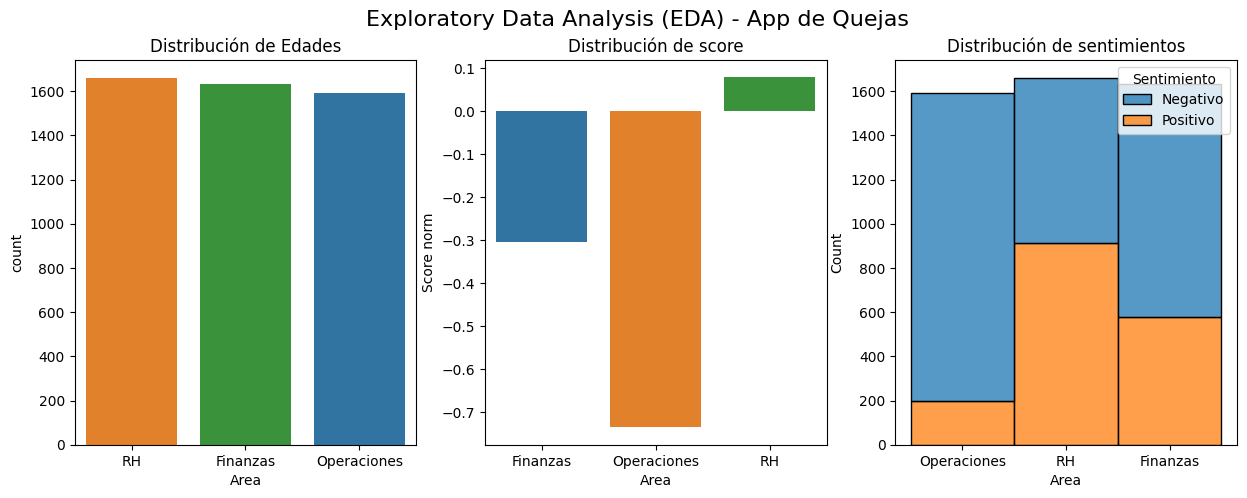

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Exploratory Data Analysis (EDA) - App de Quejas", fontsize=16)

sns.countplot(data=app_quejas, x="Area", order=app_quejas["Area"].value_counts().index, hue ="Area", ax=axes[0])
axes[0].set_title("Distribución de Edades")

area_scores = app_quejas.groupby('Area')['Score norm'].mean().reset_index()
sns.barplot(x='Area', y='Score norm', data=area_scores, hue ="Area", ax=axes[1])
axes[1].set_title("Distribución de score")

sns.histplot(data=app_quejas, x="Area", hue="Sentimiento", multiple="stack", discrete=True, ax=axes[2])
axes[2].set_title("Distribución de sentimientos")

# plt.title("Número de Quejas por Área")
# plt.xlabel("Área")
# plt.ylabel("Número de Quejas")
# plt.xticks(rotation=45)
# plt.show()


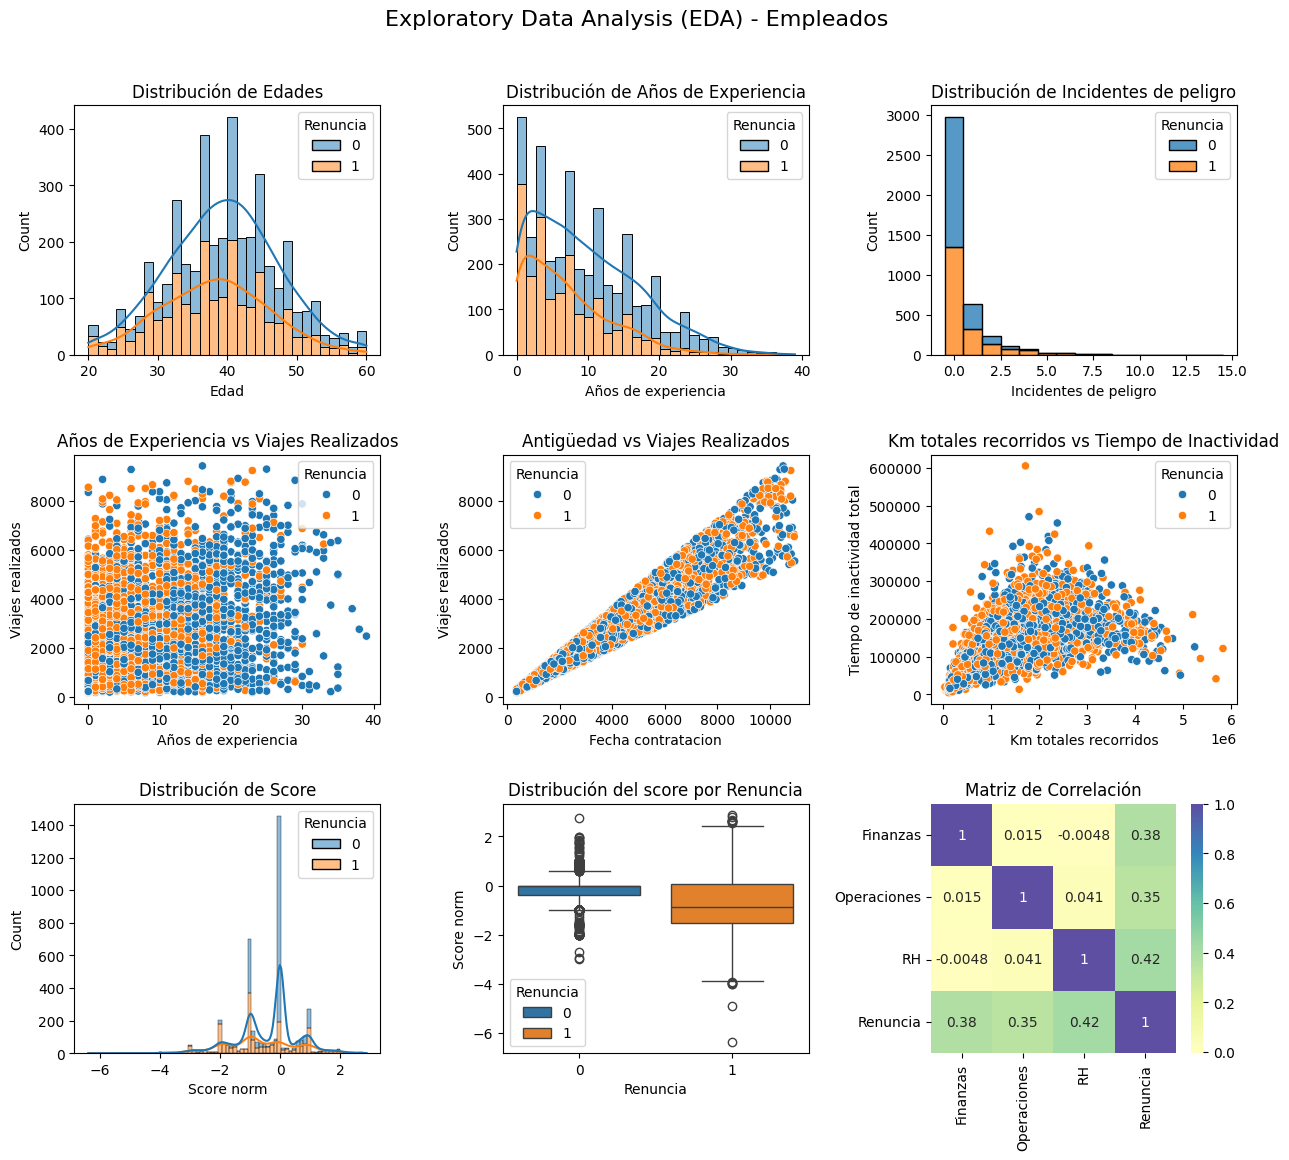

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle("Exploratory Data Analysis (EDA) - Empleados", fontsize=16)
fig.subplots_adjust(top=0.9, hspace=0.4, wspace=0.4)

sns.histplot(data=empleados, x="Edad", hue="Renuncia", multiple="stack", kde=True, ax=axes[0, 0])
axes[0, 0].set_title("Distribución de Edades")

sns.histplot(data=empleados, x="Años de experiencia", hue="Renuncia", multiple="stack", kde=True, ax=axes[0, 1])
axes[0, 1].set_title("Distribución de Años de Experiencia")

sns.histplot(data=empleados, x="Incidentes de peligro", hue="Renuncia", multiple="stack", discrete=True, ax=axes[0, 2])
axes[0, 2].set_title("Distribución de Incidentes de peligro")

sns.scatterplot(data=empleados, x="Años de experiencia", y="Viajes realizados", hue="Renuncia",ax=axes[1, 0])
axes[1, 0].set_title("Años de Experiencia vs Viajes Realizados")

antiguedad = (pd.to_datetime('03/01/2025') - empleados['Fecha contratacion']).dt.days
sns.scatterplot(data=empleados, x=antiguedad, y="Viajes realizados", hue="Renuncia",ax=axes[1, 1])
axes[1, 1].set_title("Antigüedad vs Viajes Realizados")

sns.scatterplot(data=empleados, x="Km totales recorridos", y="Tiempo de inactividad total", hue="Renuncia",ax=axes[1, 2])
axes[1, 2].set_title("Km totales recorridos vs Tiempo de Inactividad")

sns.histplot(data=joined_data, x="Score norm", hue="Renuncia", multiple="stack", kde=True, ax=axes[2, 0])
axes[2, 0].set_title("Distribución de Score")

sns.boxplot(data=joined_data, x="Renuncia", y="Score norm", hue="Renuncia",ax=axes[2, 1])
axes[2, 1].set_title("Distribución del score por Renuncia")

corr_matrix = joined_data[["Finanzas", "Operaciones", "RH", "Renuncia"]].corr()
sns.heatmap(corr_matrix, annot=True, cmap="Spectral", center=0, ax=axes[2, 2])
axes[2, 2].set_title("Matriz de Correlación")


plt.show()


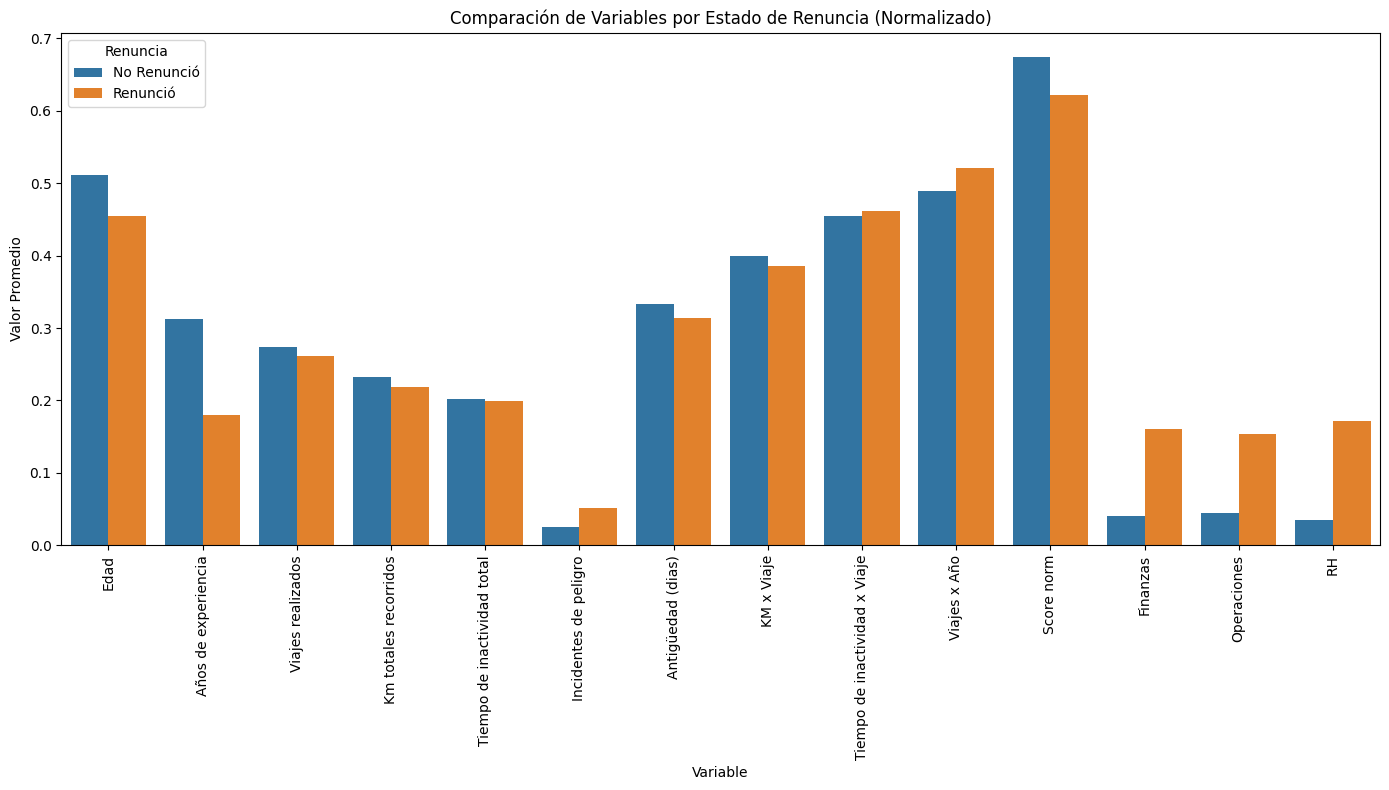

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

numeric_columns = joined_data.select_dtypes(include=['float64', 'int64']).columns
numeric_columns = numeric_columns.drop(['Renuncia']).tolist()

standardized_data = joined_data.copy()
# Normalizar todas las variables numericas para poder compararlas
standardized_data[numeric_columns] = scaler.fit_transform(standardized_data[numeric_columns])

# Analizar su distribución respecto a la renunci
resultado = standardized_data.groupby('Renuncia')[numeric_columns].mean().reset_index().round(3)
resultado['Renuncia'] = resultado['Renuncia'].map({0: 'No Renunció', 1: 'Renunció'})

resultado = resultado.melt(id_vars=['Renuncia'], var_name='Variable', value_name='Valor')

# Crear gráfico
plt.figure(figsize=(14, 8))
sns.barplot(data=resultado, x='Variable', y='Valor', hue='Renuncia')

# Personalización del gráfico
plt.xticks(rotation=90)
plt.title('Comparación de Variables por Estado de Renuncia (Normalizado)')
plt.ylabel('Valor Promedio')
plt.xlabel('Variable')
plt.legend(title='Renuncia', loc='upper left')
plt.tight_layout()

plt.show()

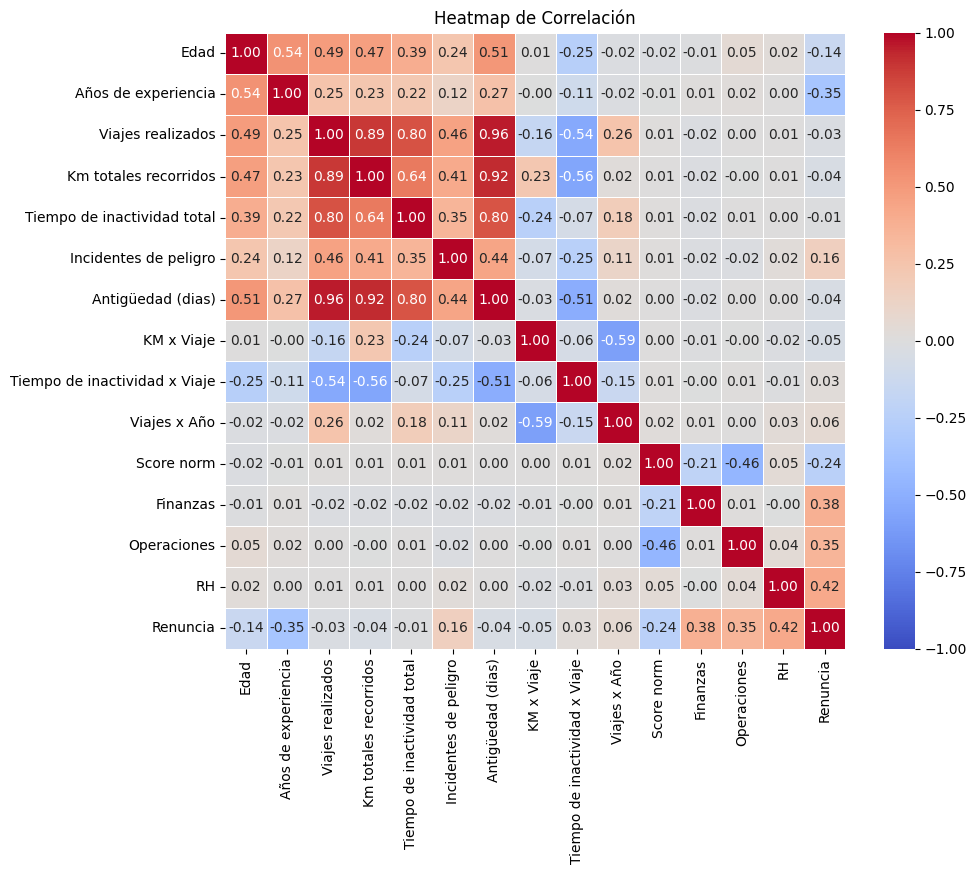

In [ ]:
correlation_matrix = joined_data[numeric_columns + ['Renuncia']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)

plt.title("Heatmap de Correlación")
plt.show()

In [ ]:
from scipy import stats

# Resultado de la agrupación por 'Renuncia'
grupo_renuncio = joined_data[joined_data['Renuncia'] == 1][numeric_columns]
grupo_no_renuncio = joined_data[joined_data['Renuncia'] == 0][numeric_columns]

# Crear un diccionario para almacenar los resultados de la prueba t
p_values = {}

# Realizar la prueba t para cada columna numérica
for col in numeric_columns:
    t_stat, p_value = stats.ttest_ind(grupo_renuncio[col], grupo_no_renuncio[col], nan_policy='omit')
    p_values[col] = p_value

# Crear un DataFrame y ordenarlo de menor a mayor
p_values_df = pd.DataFrame(list(p_values.items()), columns=['Variable', 'P-value'])
p_values_df = p_values_df.sort_values(by='P-value', ascending=True).reset_index(drop=True)

# Mostrar la tabla ordenada
print("P-values de la prueba t:")
print(p_values_df.round(4))

P-values de la prueba t:
                         Variable  P-value
0                              RH   0.0000
1                        Finanzas   0.0000
2             Años de experiencia   0.0000
3                     Operaciones   0.0000
4                      Score norm   0.0000
5           Incidentes de peligro   0.0000
6                            Edad   0.0000
7                    Viajes x Año   0.0004
8                      KM x Viaje   0.0009
9           Km totales recorridos   0.0064
10              Antigüedad (dias)   0.0076
11              Viajes realizados   0.0564
12  Tiempo de inactividad x Viaje   0.1070
13    Tiempo de inactividad total   0.4120


## ML

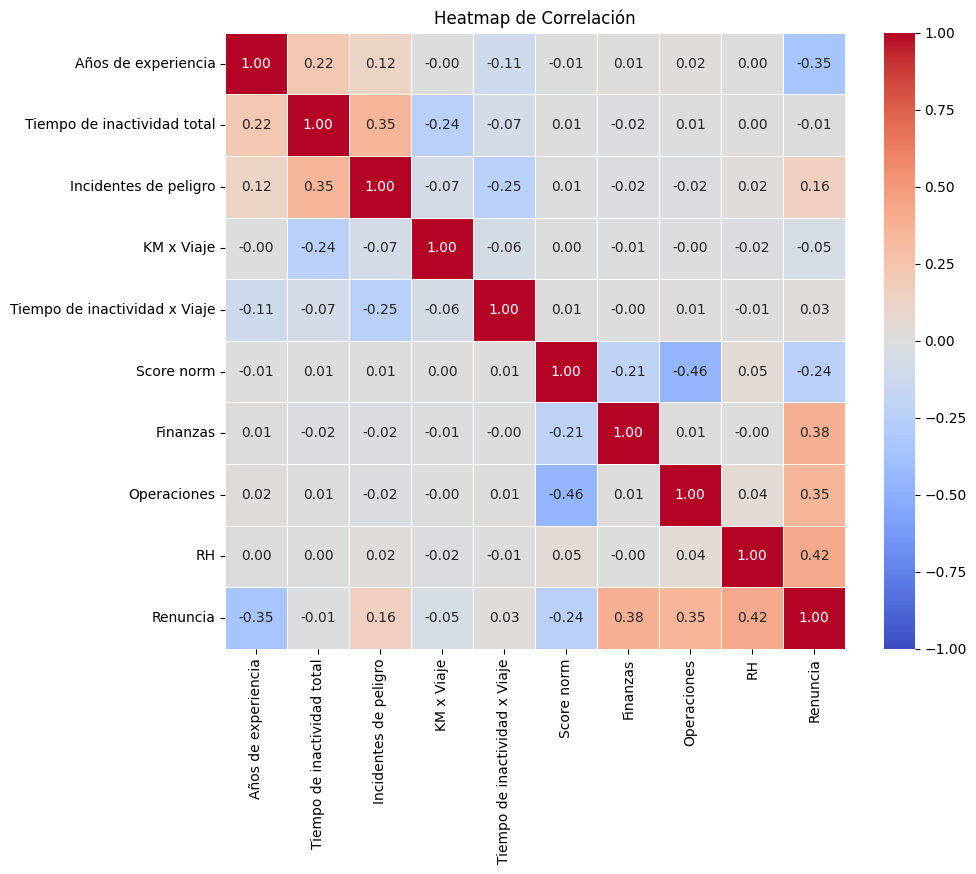

,Años de experiencia,Tiempo de inactividad total,Incidentes de peligro,KM x Viaje,Tiempo de inactividad x Viaje,Score norm,Finanzas,Operaciones,RH,Renuncia
Años de experiencia,1.000000,0.221552,0.123105,-0.004546,-0.106713,-0.006427,0.012168,0.021928,0.002639,-0.351398
Tiempo de inactividad total,0.221552,1.000000,0.348655,-0.243566,-0.069291,0.011213,-0.016454,0.006085,0.002958,-0.012834
Incidentes de peligro,0.123105,0.348655,1.000000,-0.072880,-0.249372,0.013347,-0.019532,-0.022142,0.023522,0.159497
KM x Viaje,-0.004546,-0.243566,-0.072880,1.000000,-0.055458,0.004199,-0.013085,-0.004831,-0.016132,-0.051693
Tiempo de inactividad x Viaje,-0.106713,-0.069291,-0.249372,-0.055458,1.000000,0.007868,-0.004907,0.010317,-0.012557,0.025212
Score norm,-0.006427,0.011213,0.013347,0.004199,0.007868,1.000000,-0.210683,-0.456302,0.045097,-0.241052
Finanzas,0.012168,-0.016454,-0.019532,-0.013085,-0.004907,-0.210683,1.000000,0.014624,-0.004771,0.380347
Operaciones,0.021928,0.006085,-0.022142,-0.004831,0.010317,-0.456302,0.014624,1.000000,0.040950,0.351366
RH,0.002639,0.002958,0.023522,-0.016132,-0.012557,0.045097,-0.004771,0.040950,1.000000,0.418194
Renuncia,-0.351398,-0.012834,0.159497,-0.051693,0.025212,-0.241052,0.380347,0.351366,0.418194,1.000000


In [ ]:
predictor_columns = [x for x in numeric_columns if x not in ['Antigüedad (dias)', 'Viajes realizados','Km totales recorridos','Edad','Viajes x Año']]
correlation_matrix = joined_data[predictor_columns + ['Renuncia']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)

plt.title("Heatmap de Correlación")
plt.show()
correlation_matrix

In [ ]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler

# Crear las variables X (independientes) y (dependiente)
X = joined_data[predictor_columns]  # Características
y = joined_data['Renuncia']  # Objetivo

# Estandarizamos los datos
scaler = StandardScaler()
X[predictor_columns] = scaler.fit_transform(X)
X = sm.add_constant(X)

# Dividimos los datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Se define y entrena modelo de regresión logística
model = sm.Logit(y_train, X_train)
result = model.fit()

print(result.summary())

# Realizar las predicciones
y_pred = result.predict(X_test)
y_pred_binary = (y_pred >= 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

Optimization terminated successfully.
         Current function value: 0.105367
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:               Renuncia   No. Observations:                 3271
Model:                          Logit   Df Residuals:                     3261
Method:                           MLE   Df Model:                            9
Date:                Fri, 21 Mar 2025   Pseudo R-squ.:                  0.8470
Time:                        02:14:38   Log-Likelihood:                -344.66
converged:                       True   LL-Null:                       -2253.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             0.8141      0.107      7.639      0

<ipython-input-20-c6c624616a68>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[predictor_columns] = scaler.fit_transform(X)


In [ ]:
print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')

Accuracy: 0.9645476772616137
F1 Score: 0.9307875894988067


In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

# Crear las variables X (independientes) y (dependiente)
X = joined_data[predictor_columns]  # Características
y = joined_data['Renuncia']  # Objetivo

scaler = StandardScaler()
X = X.copy()
X[predictor_columns] = scaler.fit_transform(X[predictor_columns])

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

# Dividimos los datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)

param_grid = {
    'max_depth': [3],
    'learning_rate': [0.3, 0.35],
    'n_estimators': [150,175]
}

xgb_model = xgb.XGBClassifier()

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

y_pred = grid_search.best_estimator_.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

# Calcular F1 score
f1 = f1_score(y_test, y_pred)

print("Mejores parámetros:", grid_search.best_params_)
print("Mejor score de validación:", grid_search.best_score_)

print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')


Mejores parámetros: {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 150}
Mejor score de validación: 0.9428378066625014
Accuracy: 0.965352449223417
F1 Score: 0.936542669584245


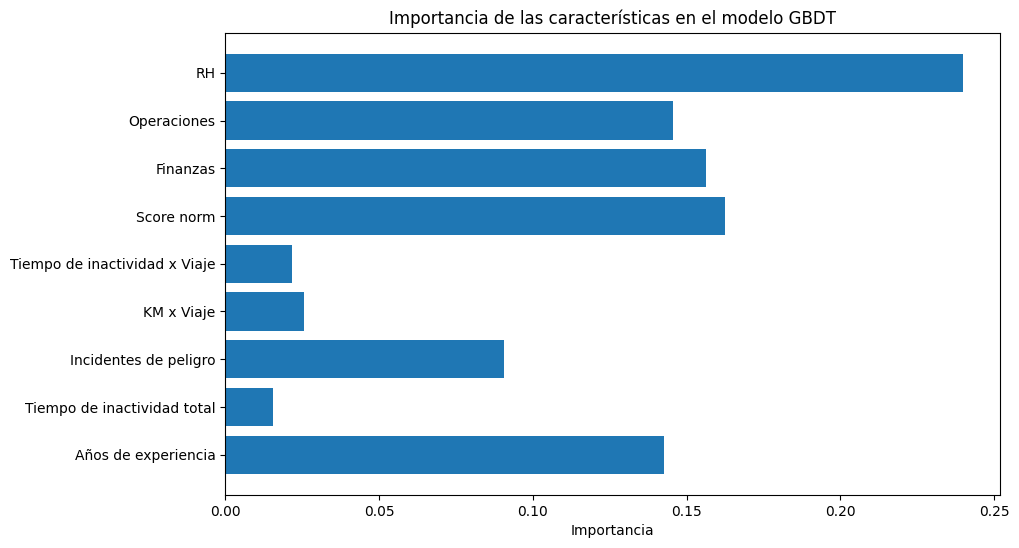

In [ ]:
import matplotlib.pyplot as plt

# Obtener la importancia de las características
importances = grid_search.best_estimator_.feature_importances_

plt.figure(figsize=(10, 6))
plt.barh(predictor_columns, importances)
plt.xlabel('Importancia')
plt.title('Importancia de las características en el modelo GBDT')
plt.show()

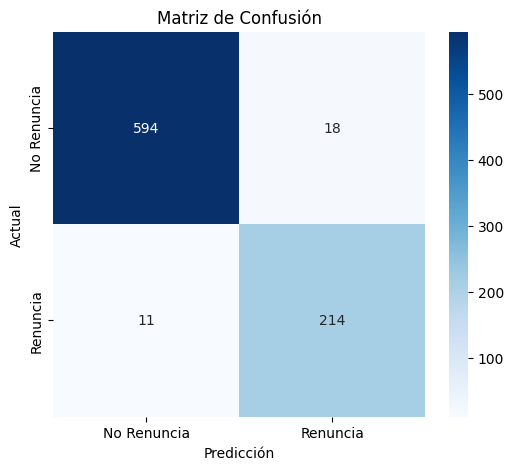

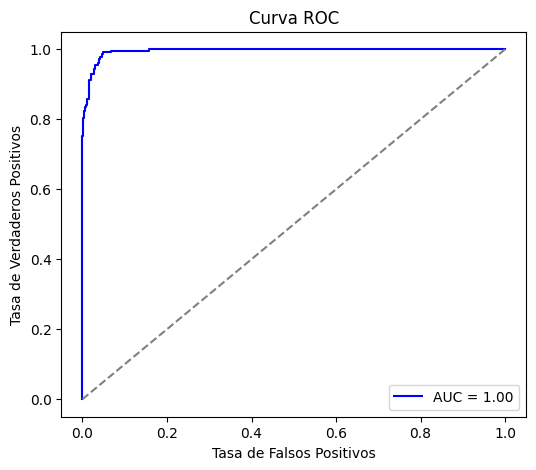

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, auc

# Matriz de Confusión
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Renuncia', 'Renuncia'], yticklabels=['No Renuncia', 'Renuncia'])
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.title('Matriz de Confusión')
plt.show()

# Curva ROC
y_prob = grid_search.best_estimator_.predict_proba(X_test)[:, 1]  # Probabilidades de la clase positiva (Renuncia)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Línea de no discriminación
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

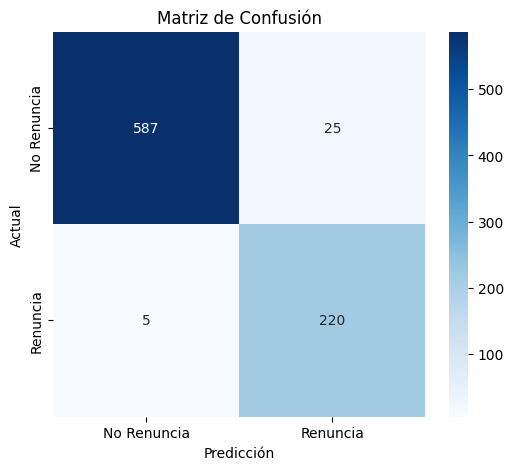

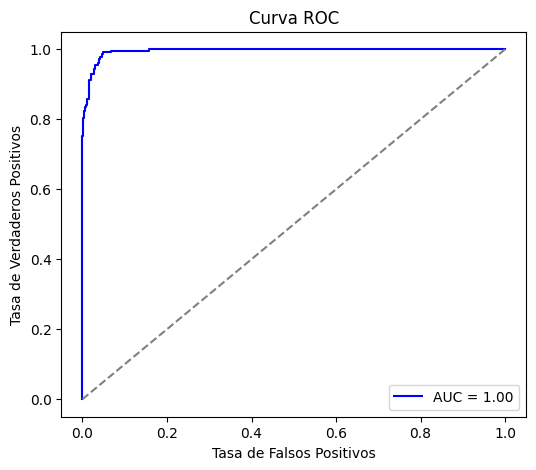

Accuracy con umbral ajustado: 0.96415770609319
F1 Score con umbral ajustado: 0.9361702127659575


In [ ]:
y_prob = grid_search.best_estimator_.predict_proba(X_test)[:, 1]  # Probabilidad de clase positiva (Renunció)

# Ajustamos el umbral para maximizar la detección de renuncias
threshold = 0.3

# Clasificamos en función del nuevo umbral
y_pred_adjusted = (y_prob >= threshold).astype(int)

# Matriz de Confusión
conf_matrix = confusion_matrix(y_test, y_pred_adjusted)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Renuncia', 'Renuncia'], yticklabels=['No Renuncia', 'Renuncia'])
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.title('Matriz de Confusión')
plt.show()

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Línea de no discriminación
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

accuracy = accuracy_score(y_test, y_pred_adjusted)
f1 = f1_score(y_test, y_pred_adjusted)

print(f'Accuracy con umbral ajustado: {accuracy}')
print(f'F1 Score con umbral ajustado: {f1}')


In [ ]:
import pickle

with open('mejor_modelo_xgb.pkl', 'wb') as archivo:
    pickle.dump(grid_search.best_estimator_, archivo)

with open('scaler.pkl', 'wb') as archivo:
    pickle.dump(scaler, archivo)